In [1]:
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

Using TensorFlow backend.


In [6]:
!retinanet-convert-model ./snapshots/resnet50_csv_40.h5 ./inference_model.h5

Using TensorFlow backend.
2019-04-29 21:52:23.757182: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-04-29 21:52:23.757235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] retrieving CUDA diagnostic information for host: HS
2019-04-29 21:52:23.757249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:170] hostname: HS
2019-04-29 21:52:23.757293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:194] libcuda reported version is: 390.116.0
2019-04-29 21:52:23.757327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:198] kernel reported version is: 390.116.0
2019-04-29 21:52:23.757340: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:305] kernel version seems to match DSO: 390.116.0


In [7]:
from keras_retinanet.models import load_model
model = load_model('./inference_model.h5', backbone_name='resnet50')

In [8]:
labels_to_names = {0: 'Healthy', 1:'Ill'}

processing time:  1.124263048171997


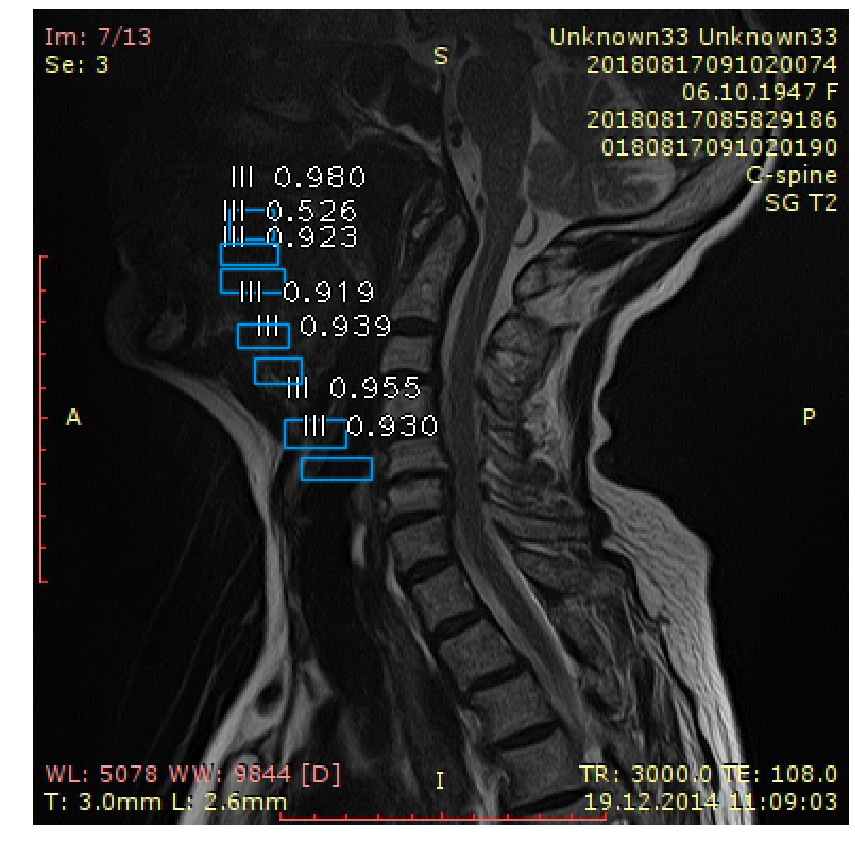

In [9]:
# load image
image = read_image_bgr('./images/img_01280.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color, thickness=1)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw, origin='upper')
plt.show()